<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#特征抽取" data-toc-modified-id="特征抽取-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>特征抽取</a></span><ul class="toc-item"><li><span><a href="#通用的特征创建模式" data-toc-modified-id="通用的特征创建模式-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>通用的特征创建模式</a></span></li></ul></li><li><span><a href="#特征选择" data-toc-modified-id="特征选择-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>特征选择</a></span></li><li><span><a href="#创建特征" data-toc-modified-id="创建特征-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>创建特征</a></span><ul class="toc-item"><li><span><a href="#主成分分析" data-toc-modified-id="主成分分析-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>主成分分析</a></span></li></ul></li><li><span><a href="#创建自己的转换器" data-toc-modified-id="创建自己的转换器-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>创建自己的转换器</a></span></li></ul></div>

文本, 图像, 声音, 视频乃至真实物体, 大多数数据挖掘算法都依赖于数值或者类别型特征  
本节介绍如何抽取特征:
 - 从数据集中抽取特征  
 - 创建新特征  
 - 选取好的特征  
 - 创建转换器,处理数据集

# 特征抽取 

In [1]:
import os
import pandas as pd
adult_filename = os.path.join(os.getcwd(), "dataset", "adult", "adult.data")
#为 adult 的列赋名
names = ["Age", 
         "Work-Class",
         "fnlwgt",
         "Education",
         "Education-Num",
        "Marital-Status",
         "Occupation",
         "Relationship",
         "Race",
         "Sex",
         "Capital-gain",
         "Capital-loss",
         "Hours-per-week",
         "Native-Country",
         "Earnings-Raw"
        ]
adult = pd.read_csv(adult_filename, header=None, names=names)
#  清楚无用行
adult.dropna(how="all", inplace=True)
adult.columns

Index(['Age', 'Work-Class', 'fnlwgt', 'Education', 'Education-Num',
       'Marital-Status', 'Occupation', 'Relationship', 'Race', 'Sex',
       'Capital-gain', 'Capital-loss', 'Hours-per-week', 'Native-Country',
       'Earnings-Raw'],
      dtype='object')

## 通用的特征创建模式
一些通用的特征关注的是研究对象的物理属性:  
 - 空间属性: 对象的长宽高
 - 重量和密度
 - 年龄,使用年限或成分
 - 种类
 - 品质
 
另一些可能与对象的使用和历史相关:
 - 生产商, 出版商, 创造者
 - 生产时间
 - 使用方法
 
还有,从组成成分描述对象:
 - 次级成分的频率, 比如词频
 - 次级成分的数量和种类数量
 - 次级成分的平均大小, 比如平均句长

In [2]:
#  pandas提供了常用统计量的特征计算
#  使用describe()方法
#  全局describe, 部分describe
import sys
import pprint
print(adult.describe())
print()
print(adult["Hours-per-week"].describe())

                Age        fnlwgt  Education-Num  Capital-gain  Capital-loss  \
count  32561.000000  3.256100e+04   32561.000000  32561.000000  32561.000000   
mean      38.581647  1.897784e+05      10.080679   1077.648844     87.303830   
std       13.640433  1.055500e+05       2.572720   7385.292085    402.960219   
min       17.000000  1.228500e+04       1.000000      0.000000      0.000000   
25%       28.000000  1.178270e+05       9.000000      0.000000      0.000000   
50%       37.000000  1.783560e+05      10.000000      0.000000      0.000000   
75%       48.000000  2.370510e+05      12.000000      0.000000      0.000000   
max       90.000000  1.484705e+06      16.000000  99999.000000   4356.000000   

       Hours-per-week  
count    32561.000000  
mean        40.437456  
std         12.347429  
min          1.000000  
25%         40.000000  
50%         40.000000  
75%         45.000000  
max         99.000000  

count    32561.000000
mean        40.437456
std         12.347

In [4]:
#  使用数据框的unique方法得到所有情况
adult["Work-Class"].unique()
# ? 代表数据集部分缺失
#  将工作时长转化为类别特征
adult["LongHours"] = (adult["Hours-per-week"]>40)

# 特征选择

通常只选取一小部分特征:  
 - 降低复杂度 
 - 降低噪声: 增加额外特征并不会总提高性能, 额外特征可能扰乱, 额外特征间的相关性和模式没有实际应用价值(在小数据集上很常见), 因此只选择合适的特征有助于减少这种几率
 - 增加模型可读性

在开始前, 有些基础测试要做  
比如, 确保特征值是不同的, 如果特征值都相同则没有信息量  
sklearn中转换器VarianceThreshold可以删除方差达不到最低标准的特征  \
小方差的数据不但没有作用, 还会拖慢运行速度

寻找最佳特征子集的复杂度, 会随着任务复杂度呈指数级增长.  
其中一个变通的方法是转而找单个特征(单变量), 依据是它们所能达到的精确度.   
分类任务通常这么做, 测量单变量和目标类别的之间的某种相关性.  

sklearn提供了集中用于选择的单变量特征转换器,  
比如  
SelectKbest返回k个最佳特征  
SelectPercentile返回表现最佳的前r%个特征

单个特征和某一类别之间的相关性的计算方法有很多,  
最常用的有卡方检验,  
还有互信息, 信息熵等  

In [5]:
#抽取如下数据, 并以收入Earnings-Raw是否达到5万作为类别进行判断
X = adult[
    [
        "Age", 
        "Education-Num",
        "Capital-gain",
        "Capital-loss",
        "Hours-per-week"
    ]
].values
y =(adult['Earnings-Raw']==" >50K").values

In [6]:
# 使用select相关转换器, 卡方函数打分
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
transformer = SelectKBest(score_func=chi2, k=3)
#调用fit方法
Xt_chi2 = transformer.fit_transform(X, y)
print(Xt_chi2)
print(transformer.scores_)

[[   39  2174     0]
 [   50     0     0]
 [   38     0     0]
 ...
 [   58     0     0]
 [   22     0     0]
 [   52 15024     0]]
[8.60061182e+03 2.40142178e+03 8.21924671e+07 1.37214589e+06
 6.47640900e+03]


相关性最好的是1,3,4列, 对应年龄, 资本收益, 资本损失  
从单变量选取上, 这些就是最佳特征

In [7]:
#  或使用pearson系数(相关系数)计算相关性
from scipy.stats import pearsonr
import numpy as np
def mul_pearsonr(X, y):
    scores, pvalues = [], []
    for column in range(X.shape[1]):
        #计算该列的pearsonr系数
        cur_score, cur_p = pearsonr(X[:,column], y)
        scores.append(abs(cur_score))
        pvalues.append(abs(cur_p))
    return (np.array(scores), np.array(pvalues))
transformer = SelectKBest(score_func=mul_pearsonr, k=3)
Xt_pearsonr = transformer.fit_transform(X, y)
print(Xt_pearsonr)
print(transformer.scores_)

[[39 13 40]
 [50 13 13]
 [38  9 40]
 ...
 [58  9 40]
 [22  9 20]
 [52  9 40]]
[0.2340371  0.33515395 0.22332882 0.15052631 0.22968907]


得到的结果与卡方检验不一致, 表明特征最好没有标准答案--取决于度量标准  
下面比较在特征集在不同分类器上的效果,  
请注意几乎没有一种方法在所有情况下比另一种方法好的情况

In [8]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
score_chi2 = cross_val_score(clf, Xt_chi2, y, scoring="accuracy")
score_pearsonr = cross_val_score(clf, Xt_pearsonr, y, scoring="accuracy")
print("chi:{0}, pearsonr:{1}".format(score_chi2, score_pearsonr))

chi:[0.82911101 0.82831695 0.83108108 0.8252457  0.83200246], pearsonr:[0.77168739 0.76689189 0.77610565 0.7730344  0.7730344 ]


我们仅仅使用特征选择技术, 找到好的特征组合, 就能达到83%的正确率

# 创建特征

特征之间的相关性很强, 或者特征冗余, 都会增加算法处理困难.  
出于这个原因, 创建特征就很有必要.  
使用uci advertisement数据集进行以下实验

In [9]:
import os 
import pandas as pd
import numpy as np
from collections import defaultdict
data_filename = os.path.join(os.getcwd(),"dataset", "advertisement", "ad.data")
#  进行缺失值处理
#  字符串转浮点数
#  空缺值得处理
def convert_number(x):
    try:
        return float(x)
    except ValueError:
        return np.nan
con = defaultdict(convert_number)
#  把最后一列(编号#1558)的值转化为0/1, 该列表示每条数据的类别
#  专门创建一列
for i in range(1558):
    con[i] = convert_number
con[1558] = lambda x:1 if x.strip()=="ad." else 0
ads = pd.read_csv(data_filename, header=None, converters=con)
ads.dropna(how='any', axis=0, inplace=True)

In [74]:
#  前1558列为x矩阵, 最后一列为y矩阵
X = ads.drop(1558, axis=1).values
y = ads[1558]

## 主成分分析
发现没有相关性的特征, 能够描述数据集, 这些特征的方差跟整体方差没有多大差距  


In [11]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
Xd = pca.fit_transform(X)
np.set_printoptions(precision=3, suppress=True)
pca.explained_variance_ratio_

array([0.854, 0.145, 0.001, 0.   , 0.   ])

In [12]:
#  尝试使用PCA后的数据做分类
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
clf = DecisionTreeClassifier(random_state=14)
scores = cross_val_score(clf, Xd, y, scoring="accuracy")
print("{:.2f}".format(np.mean(scores)))

0.94


PCA的好处是，能够将复杂的特征降维，同时实现在低纬度上的可视化  


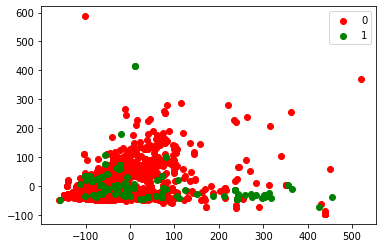

In [30]:
%matplotlib inline
from matplotlib import pyplot as plt
classes = set(y)
colors = ["red", "green"]
for cur_class, color in zip(classes, colors):
    mask = (y==cur_class).values
    plt.scatter(Xd[mask,0], Xd[mask, 1], marker='o', color=color, label=int(cur_class))
plt.legend()
plt.show()

# 创建自己的转换器 

转换器像转换函数，接收一种形式，转化成另I中形式并输出。  
转换器可以用训练集训练，训练得到的参数可以用来转换测试数据。  
转换器API：输入格式到输出格式

转换器的关键函数：  
 - fit函数接收训练数据，设置内部参数  
 - transformer函数，接收训练数据集  
 
两个函数的输入应当是相同类型的数据，transform可以返回不同类型的数据

TransformerMixin类是用来设置API的。  
使用类似Mixin这样的类，sklearn会把我们封装的类当做是转换器，方便加入到pipeline中

In [116]:
from sklearn.base import TransformerMixin
from sklearn.utils import as_float_array
#  创建继承子Mixin的类
class MeanDiscrete(TransformerMixin):
    def __init__(self, mean=0):
        self.mean = 0
    def fit(self, X, y):  #这里一定要是两个自定义参数，配合fit函数的标准用法
        #  确保X数据集是可以处理的，使用转换函数
        X = as_float_array(X)
        self.mean = X.mean(axis=0)
        return self  #  返回本身，可以链式调用，比如fit(X).transform(X)
    def transform(self, X):
        X = as_float_array(X)
        assert X.shape[1] == self.mean.shape[0]
        return X 

#mean_discrete = MeanDiscrete()
#X_mean = mean_discrete.fit_transform(X)
#cross_val_score(DecisionTreeClassifier(random_state=14), X_mean, y, scoring="accuracy")

In [118]:
# 组装流水线
from sklearn.pipeline import Pipeline
pipeline = Pipeline([('mean_discrete', MeanDiscrete()),
                    ('classifier', DecisionTreeClassifier(random_state=14))])
scores_mean_discrete = cross_val_score(pipeline, X, y, scoring="accuracy")
print("{0:.3f}".format(scores_mean_discrete.mean()))

0.939
